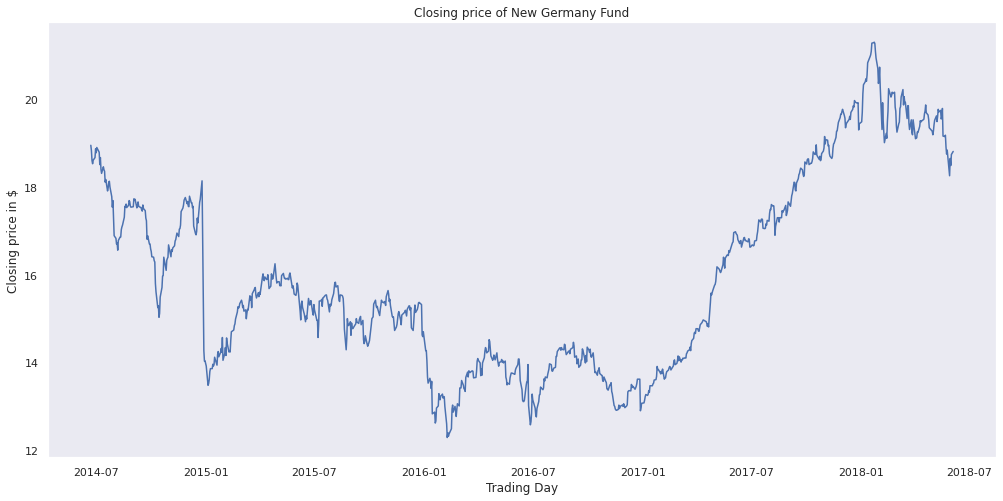

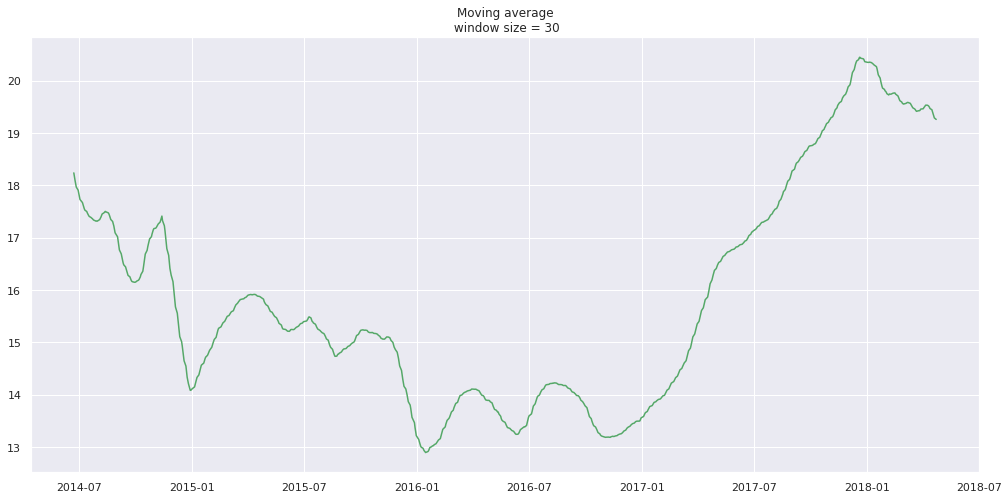

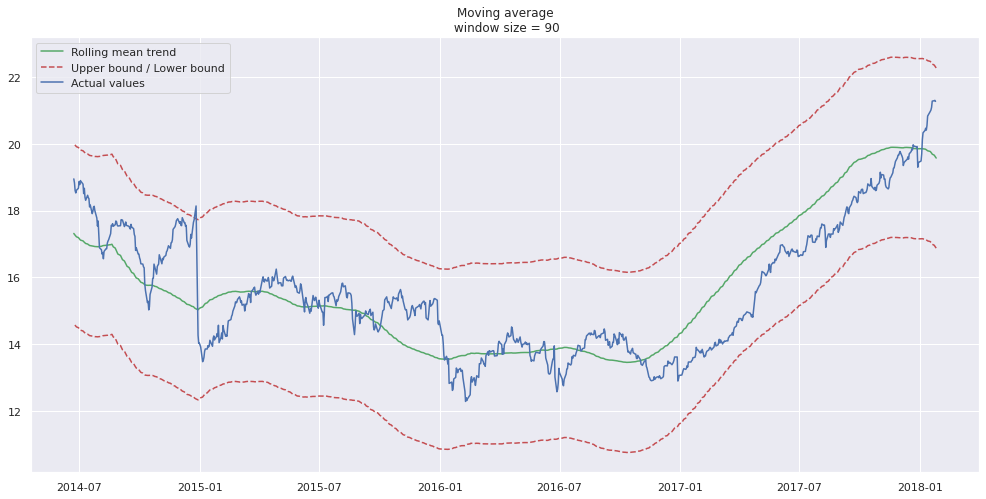

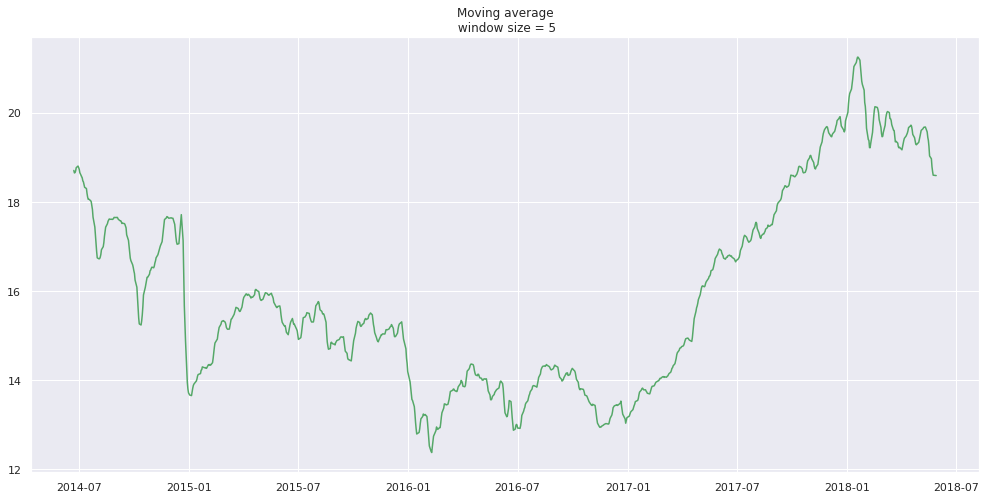

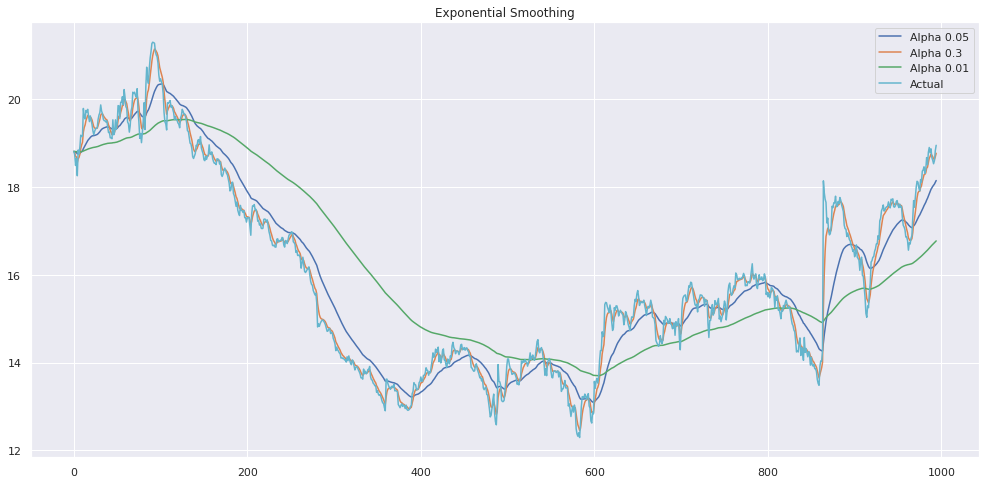

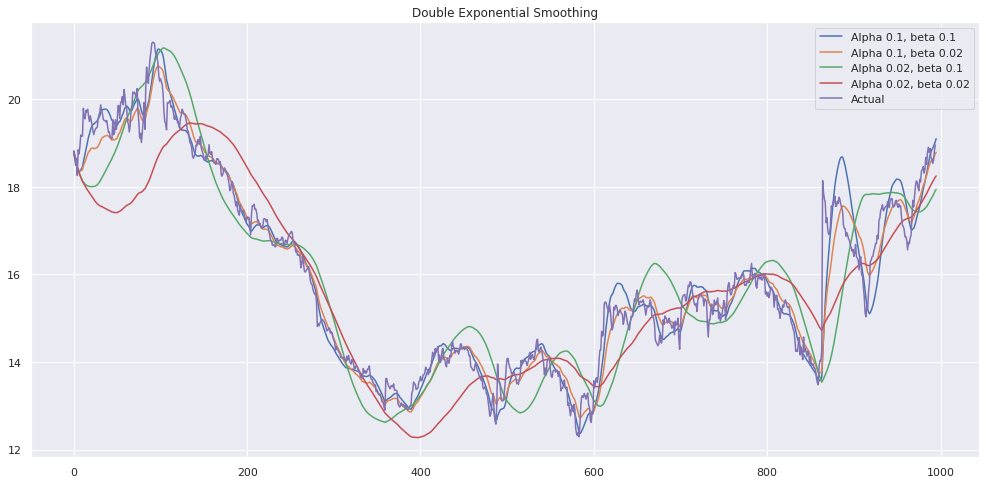

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from tqdm import tqdm_notebook

from itertools import product
def mean_absolute_percentage_error(y_true,y_pred):
  return np.mean(np.abs((y_true-y_pred)/y_true))*100

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

data=pd.read_csv('/content/stock_prices_sample.csv',index_col=['DATE'], parse_dates=['DATE'])
data.head(10)
data=data[data.TICKER!='GEF']
data.head(10)
data=data[data.TYPE!='Intraday']
drop_cols = ['SPLIT_RATIO', 'EX_DIVIDEND', 'ADJ_FACTOR', 'ADJ_VOLUME', 'ADJ_CLOSE', 'ADJ_LOW', 'ADJ_HIGH', 'ADJ_OPEN', 'VOLUME', 'FREQUENCY', 'TYPE', 'FIGI']

data.drop(drop_cols, axis=1, inplace=True)

data.head()
plt.figure(figsize=(17,8))
plt.plot(data.CLOSE)
plt.title('Closing price of New Germany Fund')
plt.xlabel('Trading Day')
plt.ylabel('Closing price in $')
plt.grid(False)
plt.show()
def plot_moving_average(series,window,plot_intervals=False,scale=1.96):
  rolling_mean=series.rolling(window=window).mean()
  plt.figure(figsize=(17,8))
  plt.title('Moving average\n window size = {}'.format(window))
  plt.plot(rolling_mean, 'g', label='Rolling mean trend')
  
  if plot_intervals:
    mae=mean_absolute_error(series[window:],rolling_mean[window:])
    deviation=np.std(series[window:]-rolling_mean[window:])
    lower_bound = rolling_mean - (mae + scale * deviation)
    upper_bound = rolling_mean + (mae + scale * deviation)
    plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
    plt.plot(lower_bound, 'r--')
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    plot_moving_average(data.CLOSE, 5)

#Smooth by the previous month (30 days)
plot_moving_average(data.CLOSE, 30)

#Smooth by previous quarter (90 days)
plot_moving_average(data.CLOSE, 90, plot_intervals=True)

def exponential_smoothing(series,alpha):
  result=[series[0]]
  for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
  return result


def plot_exponential_smoothing(series,alphas):
  plt.figure(figsize=(17,8))
  for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
  plt.plot(series.values, "c", label = "Actual")
  plt.legend(loc="best")
  plt.axis('tight')
  plt.title("Exponential Smoothing")
  plt.grid(True);

plot_exponential_smoothing(data.CLOSE,[0.05,0.3,0.01]) 
def double_exponential_smoothing(series,alpha,beta):
  result=[series[0]]
  for n in range(1,len(series)+1):
    if n==1:
      level, trend = series[0], series[1] - series[0]
    if n>=len(series):
      value=result[-1]
    else:
      value=series[n]
    last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
    trend = beta * (level - last_level) + (1 - beta) * trend
    result.append(level + trend)
  return result      

def plot_double(series,alphas,betas):
  plt.figure(figsize=(17,8))
  for i in alphas:
    for j in betas:
      plt.plot(double_exponential_smoothing(series, i, j), label="Alpha {}, beta {}".format(i, j))
  plt.plot(series.values,label="Actual")
  plt.axis('tight')
  plt.title("Double Exponential Smoothing")
  plt.legend(loc="best")
  plt.grid(True);

plot_double(data.CLOSE,alphas=[0.1,0.02],betas=[0.1,0.02])

